# Causal embedding Decoder only transformer

This notebook contains the experiments of the decoder-only transformer with causal embedding applied in the context of timeseries forecasting. The implementation is a baseline without any adjustments to the attention mechanism.

In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
plt.rcParams["pdf.use14corefonts"] = True

from src.Datasets.SyntheticDataset import SimpleSyntheticDataset
from src.Transformer.DecoderOnly import ConvolutionalDecoderOnlyTransformer
from src.train import train_step_dec_only, val_step_dec_only
from src.utils import collate_fn

## Experiment 1: one prediction step, overlapping samples, simple synthetic dataset

Now we consider the `SimpleSyntheticTimeSeriesDataset` in which sequences overlap with each other. More specifically, the target sequence is shifted 1 step from the source sequence, which means that the prediction horizon is 1. 

### Configs

In [ ]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif  torch.cuda.is_available():    
    device = 'cuda'
else:
    device = 'cpu'
    
x = torch.ones(1, device=device)
print(x)

In [2]:
seq_len = 140                           # sequence length of each sample
n_timeseries = 1                        # number of multivariate time series
shift = 1                               # number of steps to predict at once  
total_length = 6000+seq_len+shift       # full length of timeseries

emb_size = 32                           # size of transformer block embedding (d_model)
n_hidden = 64                           # Query, Key, Value projection dimension (self-attention)
ffn_n_hidden = 1024                    # point-wise feed forward net hidden dimensions
n_heads = 1                             # number of attention heads in multi-head attention
n_layers = 3                            # number of decoder blocks
lr = 0.0005                              # initial learning rate

ps = [0.5, 0.9]                         # rho_quantile loss probs
lr_step_size = 10                       # every 30 steps decrease learning rate by gamma
lr_gamma = 0.95                          # learning rate decrease rate

EPOCHS = 100                             # training epochs

### Dataset splits

In [3]:
dataset = SimpleSyntheticDataset(len_timeseries=total_length, seq_len=seq_len, shift=shift, A1=5, A2=100)

# dataset.fX = (dataset.fX - torch.mean(dataset.fX, dim=0, keepdim=True)) / torch.std(dataset.fX, dim=0, keepdim=True)

train_set, test_set, val_set = torch.utils.data.random_split(dataset, (4500, 1000, 500))

train_dl = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_dl = DataLoader(test_set, batch_size=128, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(val_set, batch_size=64, shuffle=True, collate_fn=collate_fn)

len(train_set), len(val_set), len(test_set), len(train_dl), len(val_dl), len(test_dl)

(4500, 500, 1000, 141, 8, 8)

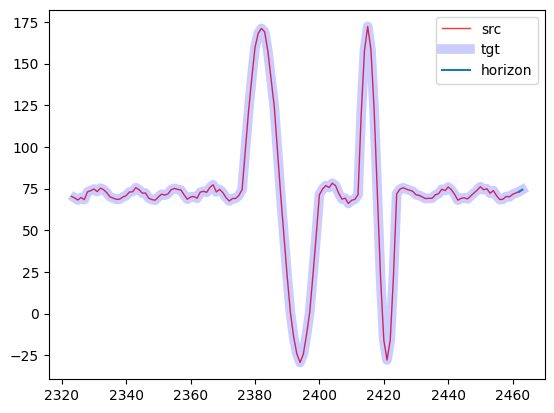

In [4]:
src_X, src_fX, tgt_X, tgt_fX = train_set[0]

plt.plot(src_X, src_fX, 'r', alpha=0.8, label='src', linewidth=1)
plt.plot(tgt_X, tgt_fX, '-b', alpha=0.2, label='tgt', linewidth=7)
plt.plot(tgt_X[-shift-1:], tgt_fX[-shift-1:], label='horizon')
plt.legend()

### Training setup

In [5]:
model = ConvolutionalDecoderOnlyTransformer(
    d_in=n_timeseries+1, 
    d_out=n_timeseries,
    emb_size=emb_size,
    n_heads=n_heads,
    n_hidden=n_hidden,
    ffn_n_hidden=ffn_n_hidden,
    num_layers=n_layers,
    norm_first=True
).to(device)

train_history = []
val_history = []
R_ps = []

# criterion = nn.SmoothL1Loss() 
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, gamma=lr_gamma)
# scheduler = get_linear_schedule_with_warmup(optimizer, EPOCHS//4, EPOCHS)

/Users/farid/miniconda3/envs/ou-dne-transformers/lib/python3.10/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


### Training

In [6]:
for epoch in range(EPOCHS):
    
    train_history.append(train_step_dec_only(model, criterion, train_dl, optimizer, dataset.mask, 0, device))
    val_loss, r_ps = val_step_dec_only(model, criterion, val_dl, ps, dataset.mask, 0, device)
    
    val_history.append(val_loss)
    R_ps.append(r_ps.tolist())
    
    scheduler.step()
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]
    print(f"{epoch=}\ttrain_loss={train_history[-1]:.4f}\tval_loss={val_history[-1]:.4f}\tR_p={R_ps_formatted}")

epoch=0	train_loss=2395.8471	val_loss=1501.7731	R_p=['0.2733', '0.2754']
epoch=1	train_loss=1076.6328	val_loss=297.4242	R_p=['0.1650', '0.1160']
epoch=2	train_loss=246.3642	val_loss=123.1901	R_p=['0.0737', '0.0817']
epoch=3	train_loss=158.7573	val_loss=103.8123	R_p=['0.0685', '0.0742']
epoch=4	train_loss=137.9656	val_loss=94.3460	R_p=['0.0650', '0.0679']
epoch=5	train_loss=124.1586	val_loss=88.7457	R_p=['0.0609', '0.0706']
epoch=6	train_loss=113.0374	val_loss=81.2875	R_p=['0.0579', '0.0669']
epoch=7	train_loss=107.4540	val_loss=80.6139	R_p=['0.0583', '0.0650']
epoch=8	train_loss=99.2663	val_loss=73.0292	R_p=['0.0565', '0.0506']
epoch=9	train_loss=93.9985	val_loss=71.2289	R_p=['0.0518', '0.0576']
epoch=10	train_loss=91.0289	val_loss=76.8280	R_p=['0.0559', '0.0735']
epoch=11	train_loss=85.3611	val_loss=68.5690	R_p=['0.0512', '0.0592']
epoch=12	train_loss=84.0207	val_loss=61.6819	R_p=['0.0487', '0.0593']
epoch=13	train_loss=79.1734	val_loss=59.7104	R_p=['0.0491', '0.0440']
epoch=14	train_

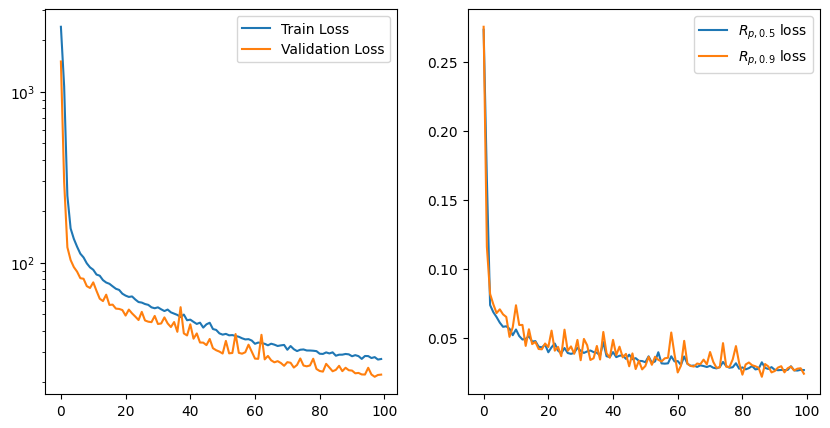

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.set_yscale('log')
ax1.plot(train_history, label="Train Loss")
ax1.plot(val_history, label="Validation Loss")
ax1.legend()

ax2.plot(R_ps, label=["$R_{p, 0.5}$ loss", "$R_{p, 0.9}$ loss"])
ax2.legend()

### Testing model

In [8]:
test_loss, r_ps = val_step_dec_only(model, criterion, test_dl, ps, dataset.mask, 0, device)

test_loss, r_ps

(23.048984008789063, tensor([0.0267, 0.0240]))

### Predict

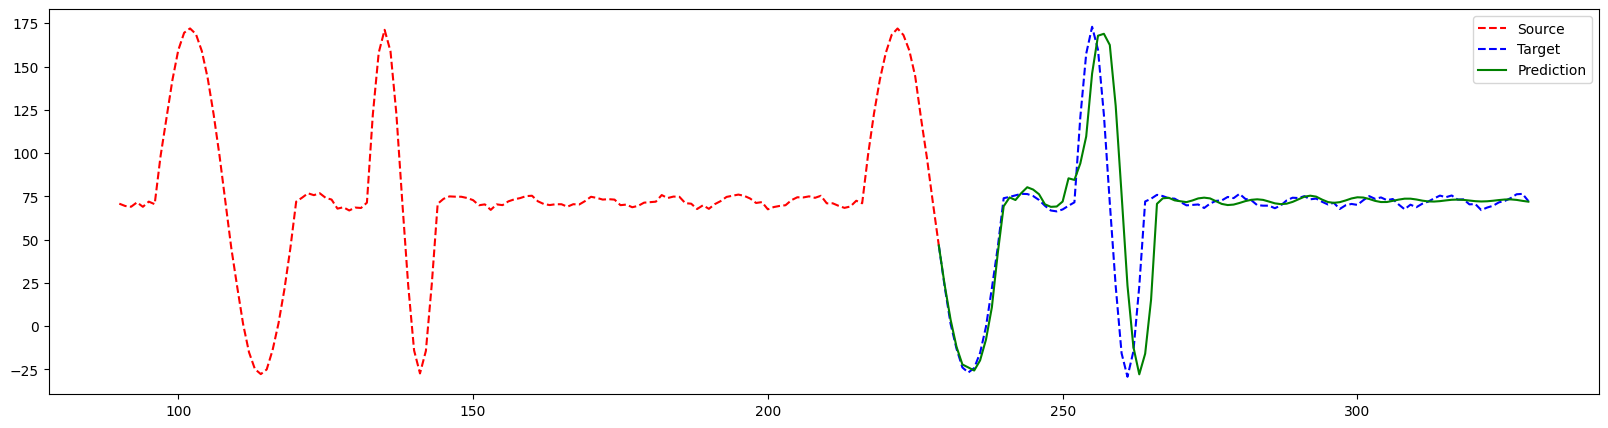

In [9]:
idx = 90
mask = dataset.mask
shift = dataset.shift
horizon = 100

tgt_X, tgt_fX = [], []
_, _, tgt_x, tgt_fx = dataset[idx-1]
tgt_X.append(tgt_x[-1].squeeze().item())
tgt_fX.append(tgt_fx[-1].squeeze().item())

attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, _, _ = (v.unsqueeze(0).to(device) for v in sample)
    pred_X = torch.clone(src_X)
    pred_fX = torch.clone(src_fX)
    mask = mask.to(device)
        
    for step in range(horizon):
        
        out = model(pred_X[:, -seq_len:], pred_fX[:, -seq_len:], mask)
        pred_fX = torch.cat([pred_fX, out[:, -shift:]], dim=1)
        pred_X = torch.cat([pred_X, pred_X[:, -1:] + 1], dim=1)
        
        attention_weights.append([block.mha.attention.attention_weight for block in model.transformer_blocks])
        
        _, _, tgt_x, tgt_fx = dataset[idx+step]
        tgt_X.append(tgt_x[-1].squeeze().item())
        tgt_fX.append(tgt_fx[-1].squeeze().item())

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source")
plt.plot(tgt_X, tgt_fX, '--b', label="Target")
plt.plot(pred_X.squeeze()[-horizon-1:].cpu(), pred_fX.squeeze()[-horizon-1:].cpu(), '-g', label="Prediction")
plt.legend()

In [10]:
inspect_step = 0

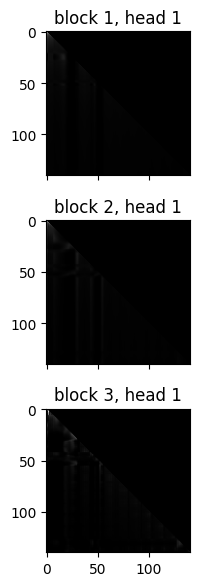

In [11]:
fig, axes = plt.subplots(n_layers, n_heads, figsize=(2*n_heads, 2*n_layers), sharex=True, sharey=True, squeeze=False)

for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        ax.imshow(attention_weights[inspect_step][i][0, j, :, :].cpu(), cmap='gray')
        ax.set_title(f"block {i+1}, head {j+1}")
plt.tight_layout()

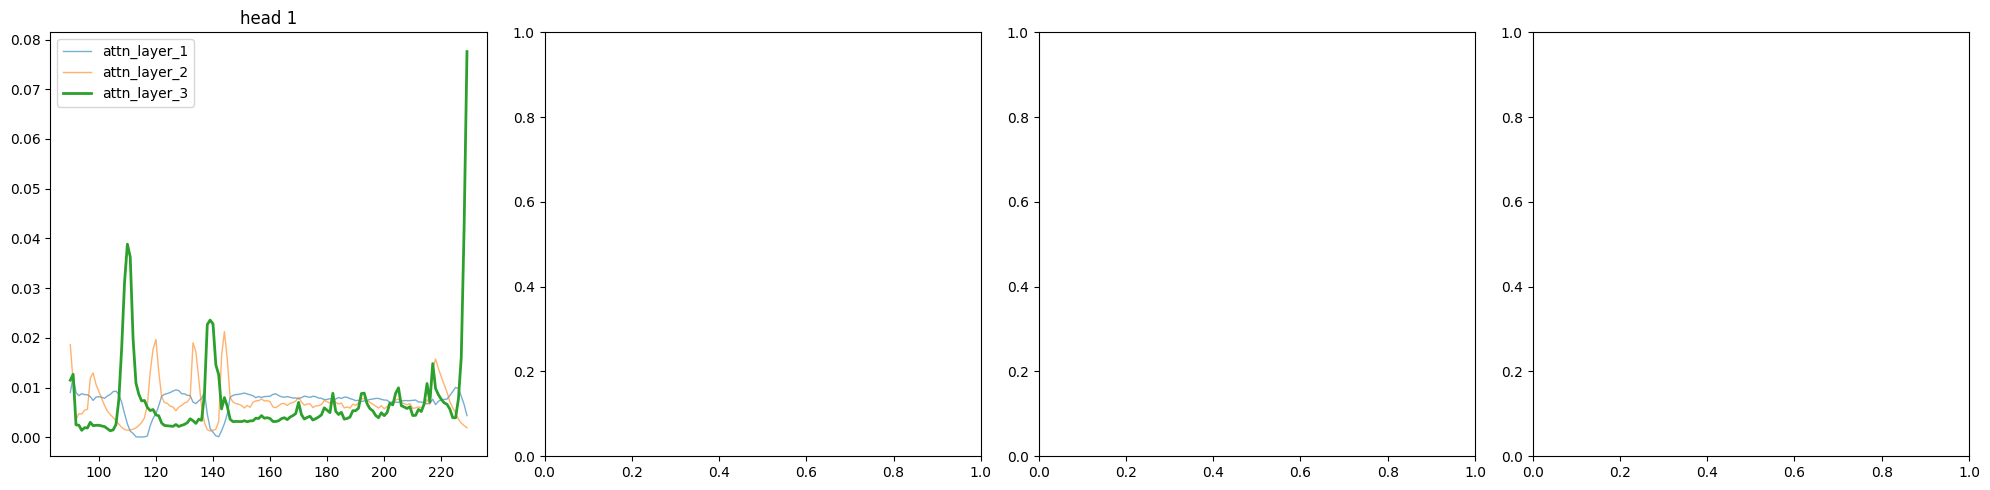

In [12]:
fig, axes = plt.subplots(n_heads//4+1, 4, figsize=(20, 5+n_heads//4 * 5))
axes = axes.flatten() 

for j, ax in zip(range(n_heads), axes):
    for i in range(n_layers):
        attn = attention_weights[inspect_step][i][0, j, -1, :].cpu() # index (inspect_step, attn_layer_i, sample_0, head_j, last row, :)
        if i == n_layers-1:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
        else:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')
        ax.set_title(f"head {j+1}")
    ax.legend()

plt.tight_layout()

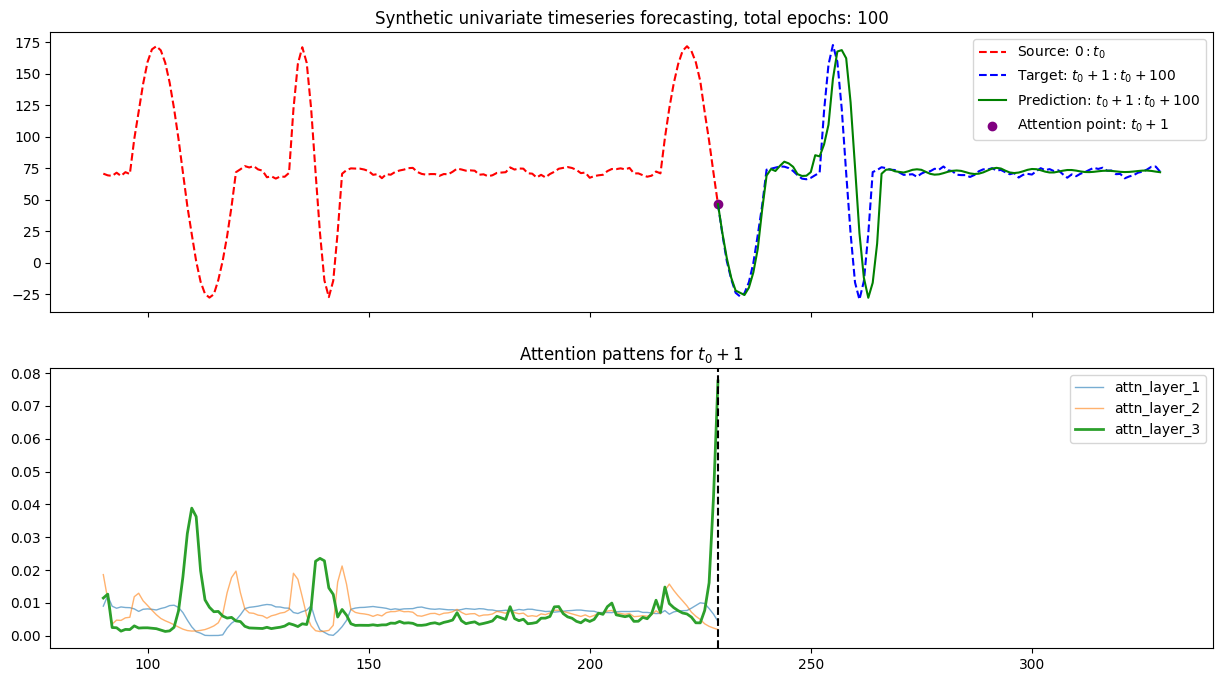

In [13]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source: $0:t_0$")
ax1.plot(tgt_X, tgt_fX, '--b', label=f"Target: $t_0+1: t_0+{horizon}$")
ax1.plot(pred_X.squeeze()[-horizon-1:].cpu(), pred_fX.squeeze()[-horizon-1:].cpu(), '-g', label=f"Prediction: $t_0+1: t_0+{horizon}$")
ax1.scatter(pred_X.squeeze()[-horizon-1+inspect_step].cpu(), pred_fX.squeeze()[-horizon-1+inspect_step].cpu(), c='purple', label=f"Attention point: $t_0 + {inspect_step+1}$")
ax1.legend()
ax1.set_title(f"Synthetic univariate timeseries forecasting, total epochs: {len(train_history)}")

for i in range(n_layers):
    attn = attention_weights[inspect_step][i][0, 0, -1, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X.squeeze().cpu()+inspect_step, attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X.squeeze().cpu()+inspect_step, attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax2.set_title(f"Attention pattens for $t_0+{inspect_step+1}$")
ax2.axvline(src_X.squeeze().cpu()[-1]+inspect_step, linestyle='--', color='k')
ax2.legend()

# fig.savefig("../../img/dec_only_baseline_attn_1pred_at_once.pdf", dpi=1200)

## Experiment 2: $n$ prediction steps, overlapping samples, simple synthetic dataset

Now we again consider the `SimpleSyntheticTimeSeriesDataset` in which sequences overlap with each other. The target sequence however is now shifted $n$ step from the source sequence, which means that the prediction horizon is $n$ steps, predicted at once. 

### Configs

In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

seq_len = 140                           # sequence length of each sample
n_timeseries = 1                        # number of multivariate time series
shift = 100                              # number of steps to predict at once
total_length = 6000+seq_len+shift       # full length of timeseries

emb_size = 32                           # size of transformer block embedding (d_model) 
n_hidden = 64                           # Query, Key, Value projection dimension (self-attention)
ffn_n_hidden = 1024                     # point-wise feed forward net hidden dimensions
n_heads = 1                             # number of attention heads in multi-head attention
n_layers = 3                            # number of decoder blocks
lr = 0.0005                              # initial learning rate

ps = [0.5, 0.9]                         # rho_quantile loss probs
lr_step_size = 10                       # every 30 steps decrease learning rate by gamma
lr_gamma = 0.95                          # learning rate decrease rate

EPOCHS = 100                             # training epochs

### Dataset splits

In [15]:
dataset = SimpleSyntheticDataset(len_timeseries=total_length, seq_len=seq_len, shift=shift, A1=5, A2=100)

train_set, test_set, val_set = torch.utils.data.random_split(dataset, (4500, 1000, 500))

train_dl = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_dl = DataLoader(test_set, batch_size=128, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(val_set, batch_size=64, shuffle=True, collate_fn=collate_fn)

len(train_set), len(val_set), len(test_set), len(train_dl), len(val_dl), len(test_dl)

(4500, 500, 1000, 141, 8, 8)

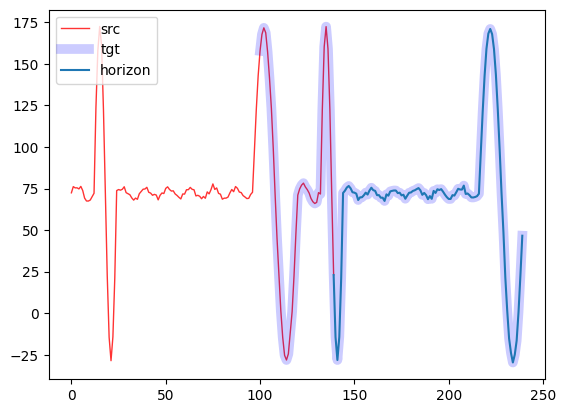

In [16]:
src_X, src_fX, tgt_X, tgt_fX = dataset[0]

plt.plot(src_X, src_fX, 'r', alpha=0.8, label='src', linewidth=1)
plt.plot(tgt_X, tgt_fX, '-b', alpha=0.2, label='tgt', linewidth=7)
plt.plot(tgt_X[-shift-1:], tgt_fX[-shift-1:], label='horizon')
plt.legend()

### Training setup

In [17]:
model = ConvolutionalDecoderOnlyTransformer(
    d_in=n_timeseries+1, 
    d_out=n_timeseries,
    emb_size=emb_size,
    n_heads=n_heads,
    num_layers=n_layers,
    norm_first=True
).to(device)

train_history = []
val_history = []
test_history = []
R_ps = []

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, lr_gamma)
# scheduler = get_linear_schedule_with_warmup(optimizer, EPOCHS//4, EPOCHS)

/Users/farid/miniconda3/envs/ou-dne-transformers/lib/python3.10/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


### Training

In [18]:
for epoch in range(EPOCHS):
    
    train_history.append(train_step_dec_only(model, criterion, train_dl, optimizer, dataset.mask, 0, device))
    val_loss, r_ps = val_step_dec_only(model, criterion, val_dl, ps, dataset.mask, 0, device)
    
    val_history.append(val_loss)
    R_ps.append(r_ps.tolist())
    
    scheduler.step()
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]
    print(f"{epoch=}\ttrain_loss={train_history[-1]:.4f}\tval_loss={val_history[-1]:.4f}\tR_p={R_ps_formatted}")

epoch=0	train_loss=2096.5384	val_loss=1482.0222	R_p=['0.2700', '0.2676']
epoch=1	train_loss=1482.4944	val_loss=1386.0395	R_p=['0.2855', '0.2629']
epoch=2	train_loss=1287.5454	val_loss=920.1036	R_p=['0.2348', '0.2623']
epoch=3	train_loss=925.3227	val_loss=768.3066	R_p=['0.1868', '0.1912']
epoch=4	train_loss=789.2410	val_loss=715.5567	R_p=['0.1844', '0.1927']
epoch=5	train_loss=670.5816	val_loss=568.2064	R_p=['0.1601', '0.1628']
epoch=6	train_loss=591.5642	val_loss=443.9344	R_p=['0.1398', '0.1491']
epoch=7	train_loss=522.3264	val_loss=441.6645	R_p=['0.1456', '0.1453']
epoch=8	train_loss=486.5331	val_loss=480.6727	R_p=['0.1521', '0.1455']
epoch=9	train_loss=439.1355	val_loss=489.4617	R_p=['0.1514', '0.1373']
epoch=10	train_loss=414.9237	val_loss=371.0660	R_p=['0.1283', '0.1200']
epoch=11	train_loss=389.5411	val_loss=371.0971	R_p=['0.1327', '0.1325']
epoch=12	train_loss=360.8864	val_loss=329.7623	R_p=['0.1217', '0.1189']
epoch=13	train_loss=348.1818	val_loss=352.9475	R_p=['0.1274', '0.1042

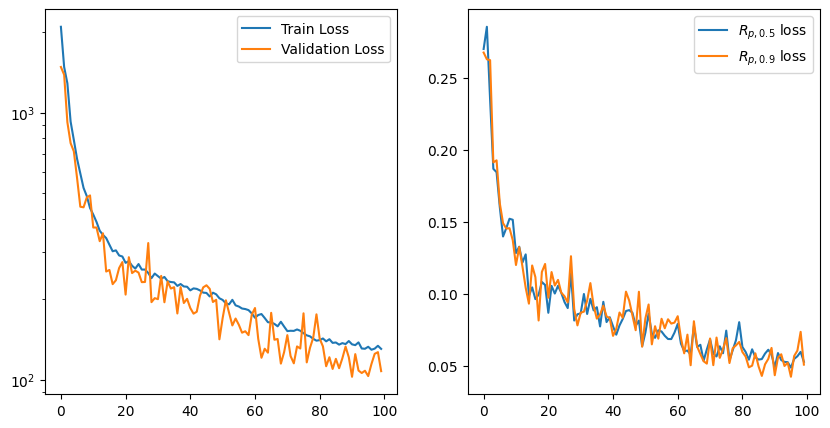

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.set_yscale('log')
ax1.plot(train_history, label="Train Loss")
ax1.plot(val_history, label="Validation Loss")
ax1.legend()

ax2.plot(R_ps, label=["$R_{p, 0.5}$ loss", "$R_{p, 0.9}$ loss"])
ax2.legend()

### Testing model

In [20]:
test_loss, r_ps = val_step_dec_only(model, criterion, test_dl, ps, dataset.mask, 0, device)

test_loss, r_ps

(121.46092529296875, tensor([0.0555, 0.0539]))

### Predict

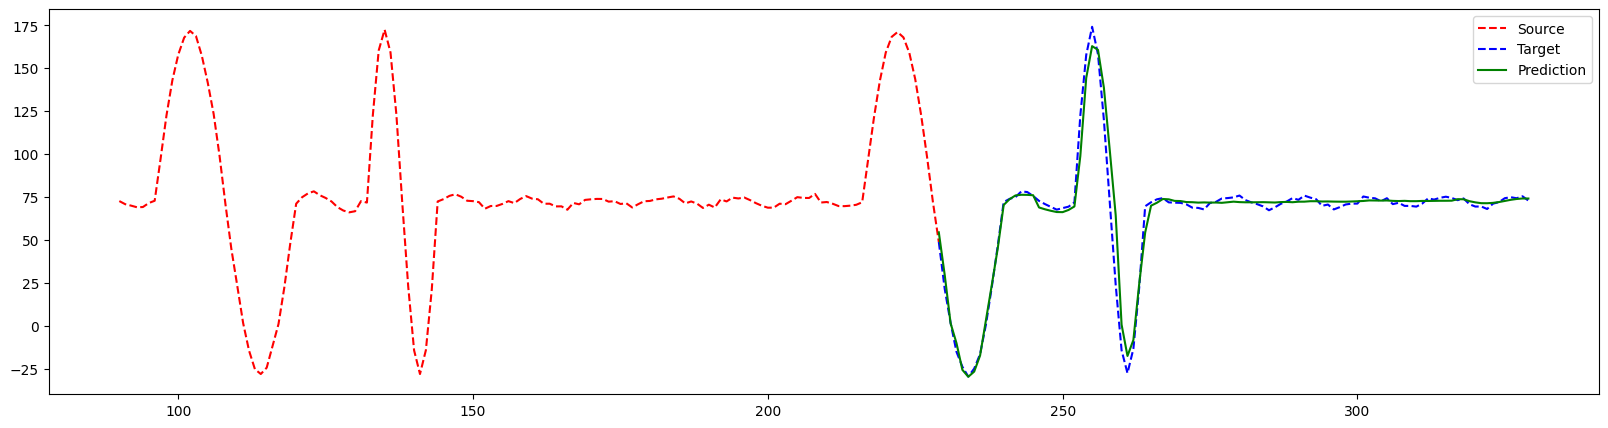

In [21]:
idx = 90
mask = dataset.mask
shift = dataset.shift

attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, tgt_X, tgt_fX = (v.unsqueeze(0).to(device) for v in sample)
    mask = mask.to(device)
    
    out = model(src_X, src_fX, mask)
    pred_fX = out[:, -shift-1:].squeeze().cpu()
    
    tgt_X = tgt_X[:, -shift-1:].squeeze().cpu()
    tgt_fX = tgt_fX[:, -shift-1:].squeeze().cpu()
    
    attention_weights.append([block.mha.attention.attention_weight for block in model.transformer_blocks])

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source")
plt.plot(tgt_X, tgt_fX, '--b', label="Target")
plt.plot(tgt_X, pred_fX, '-g', label="Prediction")
plt.legend()

In [22]:
inspect_step = 0

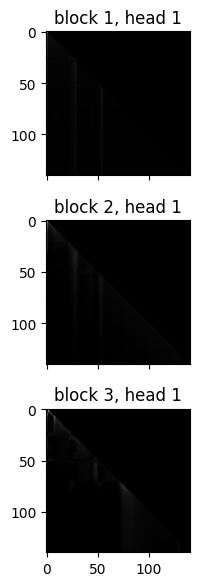

In [23]:
fig, axes = plt.subplots(n_layers, n_heads, figsize=(2*n_heads, 2*n_layers), sharex=True, sharey=True, squeeze=False)

for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        ax.imshow(attention_weights[inspect_step][i][0, j, :, :].cpu(), cmap='gray')
        ax.set_title(f"block {i+1}, head {j+1}")
plt.tight_layout()

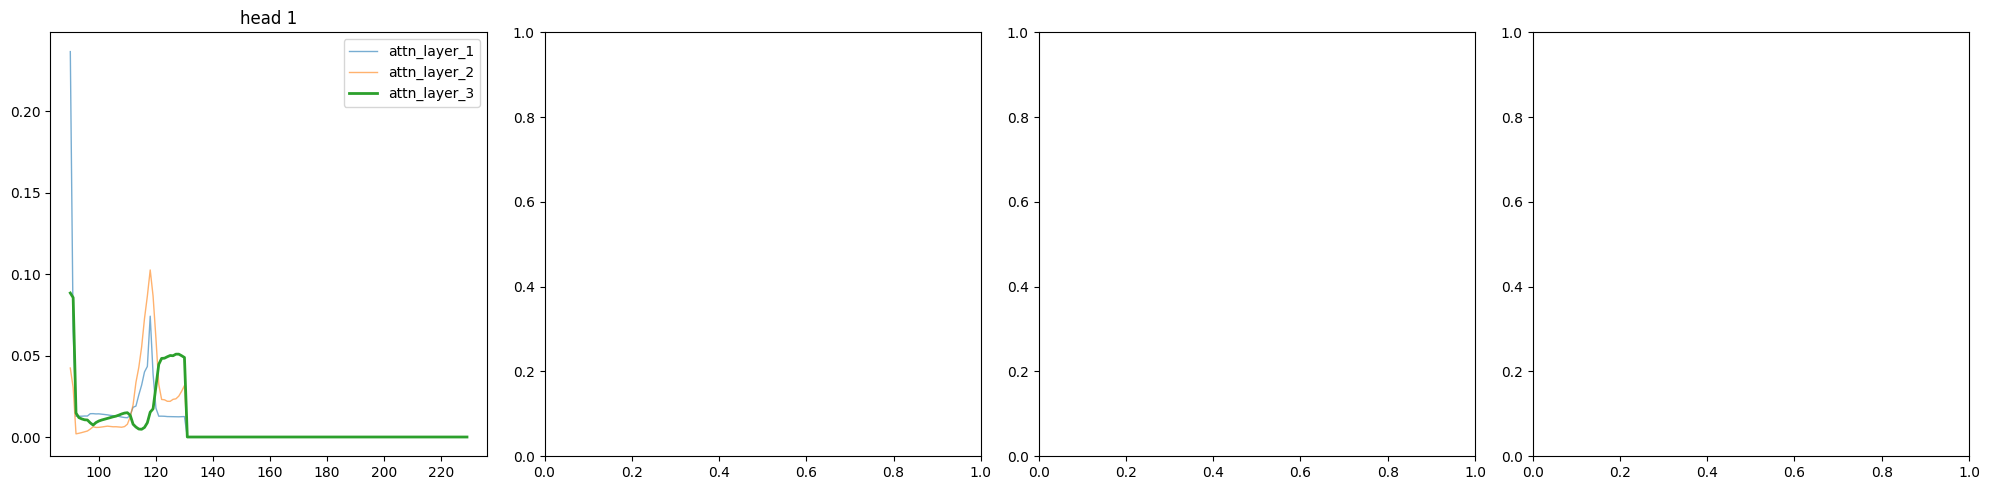

In [24]:
fig, axes = plt.subplots(n_heads//4+1, 4, figsize=(20, 5+n_heads//4 * 5))
axes = axes.flatten() 

for j, ax in zip(range(n_heads), axes):
    for i in range(n_layers):
        attn = attention_weights[inspect_step][i][0, j, -shift, :].cpu()
        if i == n_layers-1:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
        else:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')
        ax.set_title(f"head {j+1}")
    ax.legend()

plt.tight_layout()

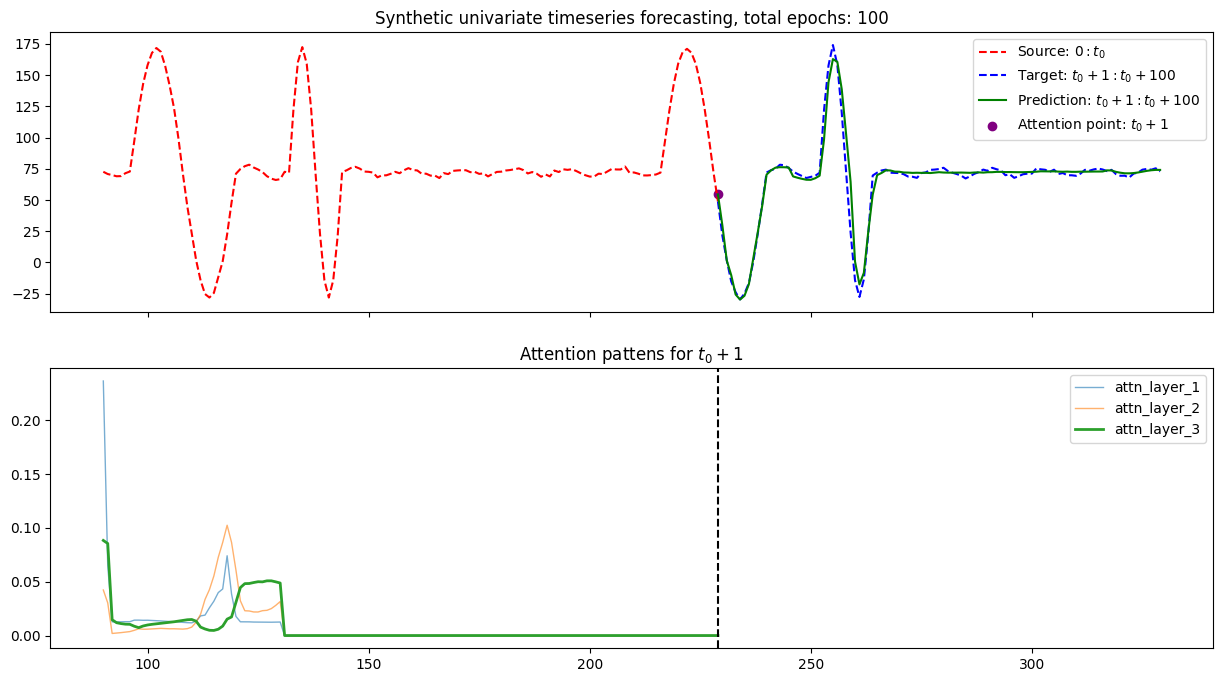

In [25]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source: $0:t_0$")
ax1.plot(tgt_X, tgt_fX, '--b', label=f"Target: $t_0+1: t_0+{shift}$")
ax1.plot(tgt_X, pred_fX, '-g', label=f"Prediction: $t_0+1: t_0+{shift}$")
ax1.scatter(pred_X.squeeze()[-horizon-1+inspect_step].cpu(), pred_fX.squeeze()[-horizon-1+inspect_step].cpu(), c='purple', label=f"Attention point: $t_0 + {inspect_step+1}$")
ax1.legend()
ax1.set_title(f"Synthetic univariate timeseries forecasting, total epochs: {len(train_history)}")

for i in range(n_layers):
    attn = attention_weights[inspect_step][i][0, 0, -shift, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X.squeeze().cpu()+inspect_step, attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X.squeeze().cpu()+inspect_step, attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')
    ax2.set_title(f"Attention pattens for $t_0+{inspect_step+1}$")

ax2.axvline(src_X.squeeze().cpu()[-1]+inspect_step, linestyle='--', color='k')
ax2.legend()

# fig.savefig(f"../../img/dec_only_baseline_attn_{shift}pred_at_once.pdf", dpi=1200)

## Experiment 3: $n$ prediction steps, non-overlapping samples, simple synthetic dataset

Now we again consider the `SimpleSyntheticTimeSeriesDataset` in which sequences do not overlap with each other. The target sequence is again shifted $n$ step from the source sequence, which means that the prediction horizon is $n$ steps, all predicted at once. 

In [26]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

seq_len = 140                           # sequence length of each sample
n_timeseries = 1                        # number of multivariate time series
shift = 100                              # number of steps to predict at once  
total_length = 6000+seq_len+shift       # full length of timeseries

emb_size = 32                           # size of transformer block embedding (d_model) 
n_hidden = 64                           # Query, Key, Value projection dimension (self-attention)
ffn_n_hidden = 1024                     # point-wise feed forward net hidden dimensions
n_heads = 1                             # number of attention heads in multi-head attention
n_layers = 3                            # number of decoder blocks
lr = 0.0005                              # initial learning rate

ps = [0.5, 0.9]                         # rho_quantile loss probs
lr_step_size = 10                       # every 30 steps decrease learning rate by gamma
lr_gamma = 0.9                          # learning rate decrease rate

EPOCHS = 100                             # training epochs

### Dataset splits

In [27]:
dataset = SimpleSyntheticDataset(len_timeseries=total_length, seq_len=seq_len, shift=shift, A1=5, A2=100, mode='nonoverlapping')

train_set, test_set, val_set = torch.utils.data.random_split(dataset, (4500, 1000, 500))

train_dl = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_dl = DataLoader(test_set, batch_size=128, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(val_set, batch_size=64, shuffle=True, collate_fn=collate_fn)

len(train_set), len(val_set), len(test_set), len(train_dl), len(val_dl), len(test_dl)

(4500, 500, 1000, 141, 8, 8)

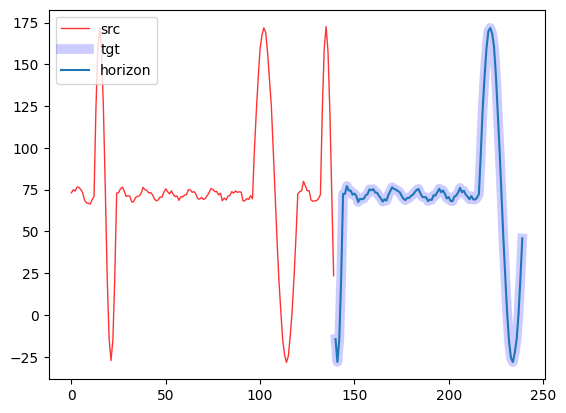

In [28]:
src_X, src_fX, tgt_X, tgt_fX = dataset[0]

plt.plot(src_X, src_fX, 'r', alpha=0.8, label='src', linewidth=1)
plt.plot(tgt_X, tgt_fX, '-b', alpha=0.2, label='tgt', linewidth=7)
plt.plot(tgt_X[-shift-1:], tgt_fX[-shift-1:], label='horizon')
plt.legend()

### Training setup

In [29]:
model = ConvolutionalDecoderOnlyTransformer(
    d_in=n_timeseries+1, 
    d_out=n_timeseries,
    emb_size=emb_size,
    n_heads=n_heads,
    num_layers=n_layers,
    norm_first=True
).to(device)

train_history = []
val_history = []
test_history = []
R_ps = []

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, lr_gamma)
# scheduler = get_linear_schedule_with_warmup(optimizer, EPOCHS//4, EPOCHS)

### Training

In [30]:
for epoch in range(EPOCHS):
    
    train_history.append(train_step_dec_only(model, criterion, train_dl, optimizer, dataset.mask, shift, device))
    val_loss, r_ps = val_step_dec_only(model, criterion, val_dl, ps, dataset.mask, shift, device)
    
    val_history.append(val_loss)
    R_ps.append(r_ps.tolist())
    
    scheduler.step()
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]
    print(f"{epoch=}\ttrain_loss={train_history[-1]:.4f}\tval_loss={val_history[-1]:.4f}\tR_p={R_ps_formatted}")

epoch=0	train_loss=2233.8998	val_loss=1494.5242	R_p=['0.2726', '0.2684']
epoch=1	train_loss=1505.7267	val_loss=1489.7504	R_p=['0.2727', '0.2739']
epoch=2	train_loss=1432.7915	val_loss=1243.7789	R_p=['0.2707', '0.2455']
epoch=3	train_loss=1162.2280	val_loss=992.4823	R_p=['0.2461', '0.2735']
epoch=4	train_loss=992.3023	val_loss=771.2679	R_p=['0.2093', '0.1983']
epoch=5	train_loss=765.4903	val_loss=793.2737	R_p=['0.2075', '0.2059']
epoch=6	train_loss=655.7788	val_loss=650.7238	R_p=['0.1856', '0.1854']
epoch=7	train_loss=580.8305	val_loss=528.4699	R_p=['0.1575', '0.1548']
epoch=8	train_loss=531.2583	val_loss=631.9585	R_p=['0.1764', '0.1772']
epoch=9	train_loss=503.0581	val_loss=565.3995	R_p=['0.1654', '0.1518']
epoch=10	train_loss=454.2864	val_loss=483.2318	R_p=['0.1480', '0.1411']
epoch=11	train_loss=421.2969	val_loss=728.1025	R_p=['0.1889', '0.1510']
epoch=12	train_loss=396.6707	val_loss=678.6053	R_p=['0.1784', '0.1436']
epoch=13	train_loss=359.9303	val_loss=419.8464	R_p=['0.1362', '0.11

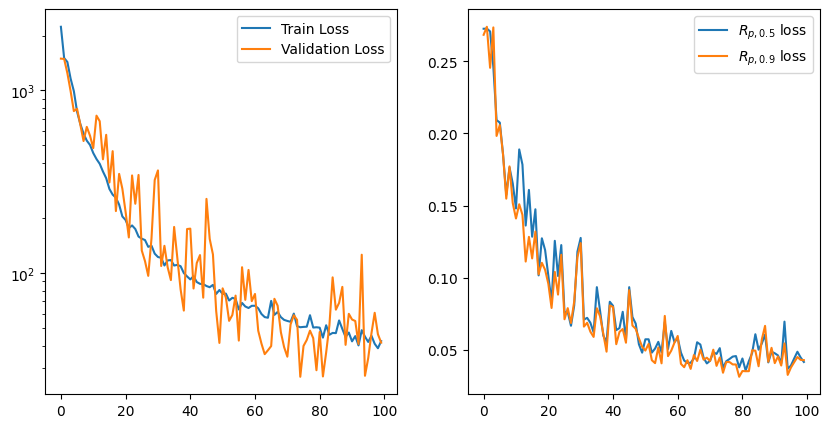

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.set_yscale('log')
ax1.plot(train_history, label="Train Loss")
ax1.plot(val_history, label="Validation Loss")
ax1.legend()

ax2.plot(R_ps, label=["$R_{p, 0.5}$ loss", "$R_{p, 0.9}$ loss"])
ax2.legend()

### Testing model

In [32]:
test_loss, r_ps = val_step_dec_only(model, criterion, test_dl, ps, dataset.mask, shift, device)

test_loss, r_ps

(39.19517807006836, tensor([0.0405, 0.0422]))

### Predict

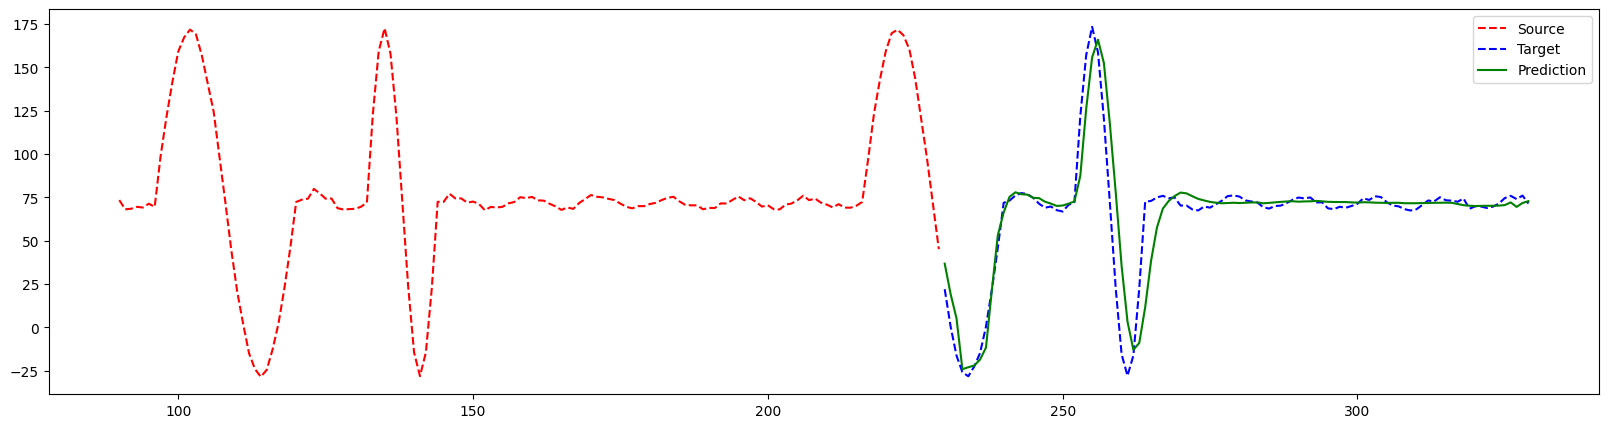

In [33]:
idx = 90 # sample to inspect
mask = dataset.mask
shift = dataset.shift

attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, tgt_X, tgt_fX = (v.unsqueeze(0).to(device) for v in sample)
    mask = mask.to(device)
    
    out = model(src_X, src_fX, mask)
    pred_fX = out[:, -shift:].squeeze().cpu()
    
    tgt_X = tgt_X.squeeze().cpu()
    tgt_fX = tgt_fX.squeeze().cpu()
    
    attention_weights.append([block.mha.attention.attention_weight for block in model.transformer_blocks])

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source")
plt.plot(tgt_X, tgt_fX, '--b', label="Target")
plt.plot(tgt_X, pred_fX, '-g', label="Prediction")
plt.legend()

In [34]:
inspect_step = 0

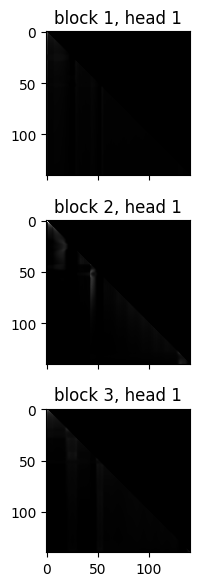

In [35]:
fig, axes = plt.subplots(n_layers, n_heads, figsize=(2*n_heads, 2*n_layers), sharex=True, sharey=True, squeeze=False)

for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        ax.imshow(attention_weights[inspect_step][i][0, j, :, :].cpu(), cmap='gray')
        ax.set_title(f"block {i+1}, head {j+1}")
plt.tight_layout()

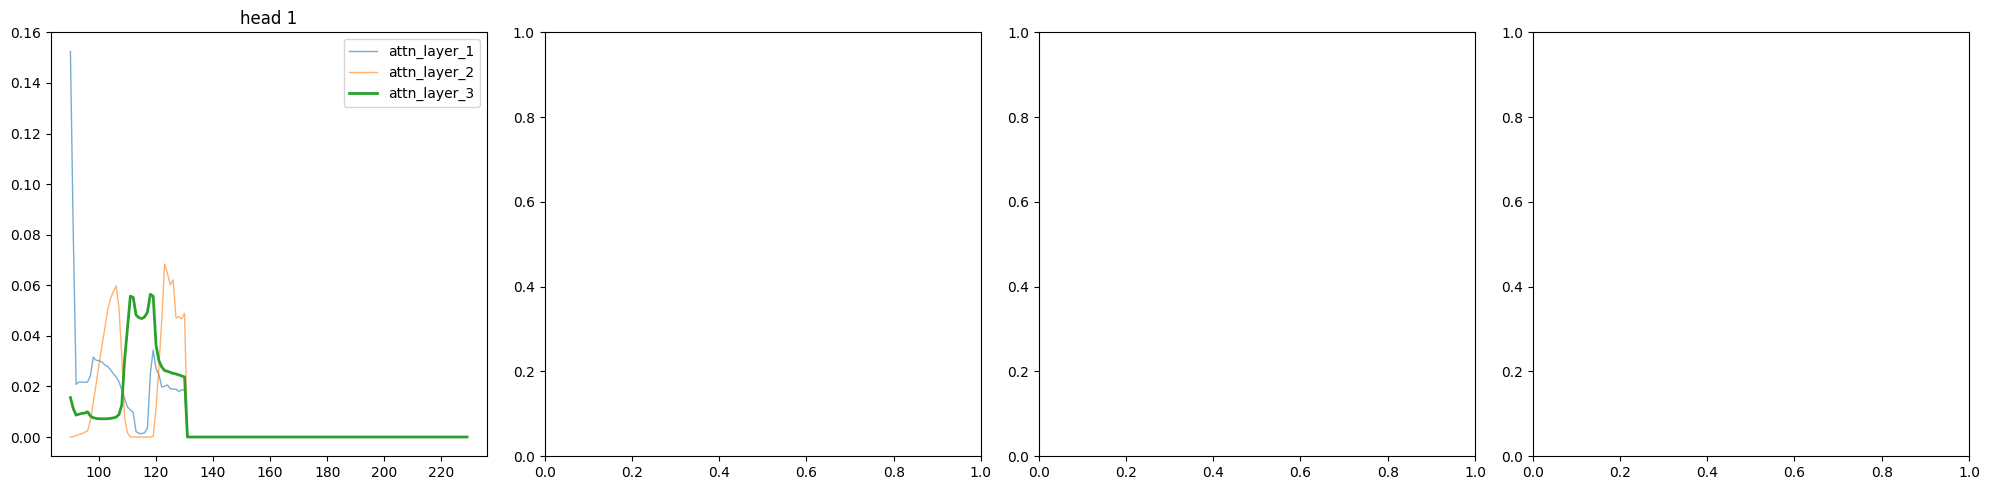

In [36]:
fig, axes = plt.subplots(n_heads//4+1, 4, figsize=(20, 5+n_heads//4 * 5))
axes = axes.flatten() 

for j, ax in zip(range(n_heads), axes):
    for i in range(n_layers):
        attn = attention_weights[inspect_step][i][0, j, -shift, :].cpu()
        if i == n_layers-1:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
        else:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')
        ax.set_title(f"head {j+1}")
    ax.legend()

plt.tight_layout()

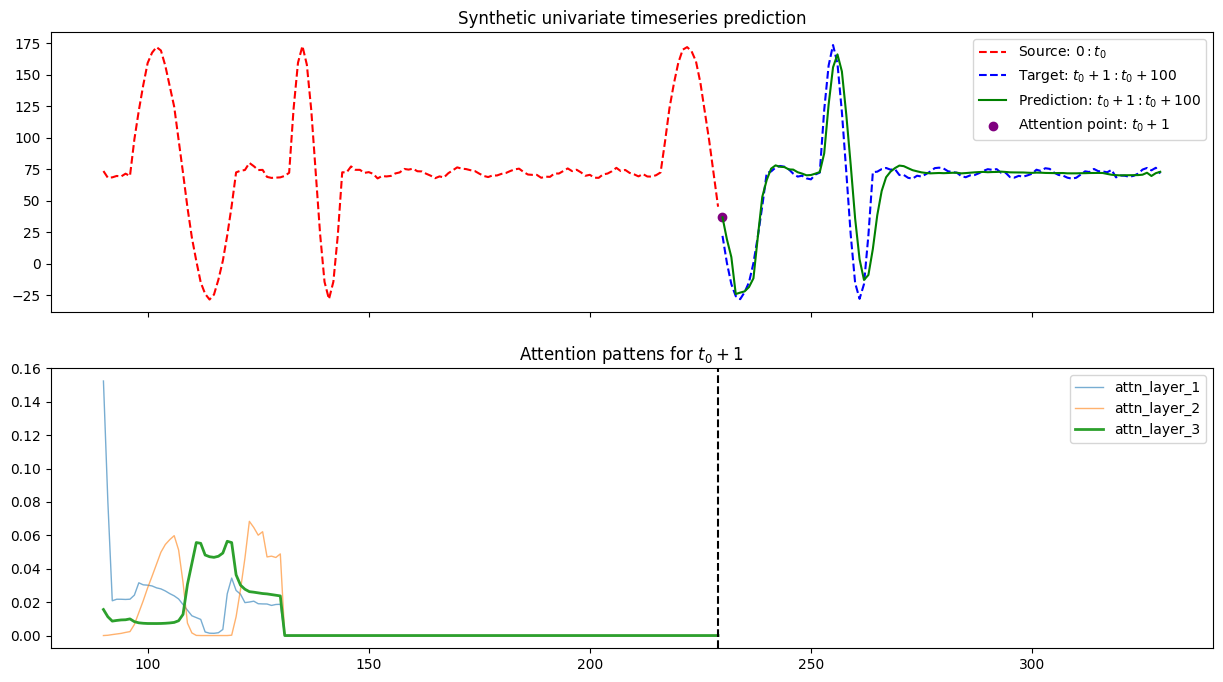

In [37]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source: $0:t_0$")
ax1.plot(tgt_X, tgt_fX, '--b', label=f"Target: $t_0+1: t_0+{shift}$")
ax1.plot(tgt_X, pred_fX, '-g', label=f"Prediction: $t_0+1: t_0+{shift}$")
ax1.scatter(tgt_X[inspect_step].cpu(), pred_fX.squeeze()[inspect_step].cpu(), c='purple', label=f"Attention point: $t_0 + {inspect_step+1}$")
ax1.legend()
ax1.set_title(f"Synthetic univariate timeseries prediction")

for i in range(n_layers):
    attn = attention_weights[inspect_step][i][0, 0, -shift, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax2.set_title(f"Attention pattens for $t_0+{inspect_step+1}$")
ax2.axvline(src_X.squeeze().cpu()[-1], linestyle='--', color='k')
ax2.legend()

# fig.savefig(f"../../img/dec_only_baseline_attn_{shift}pred_at_once_nonoverlapping.pdf", dpi=1200)